In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from datetime import datetime
import random
import os
import time

2024-11-18 17:07:59.626273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 17:08:00.599361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
# CutMix function
# Used from the link given in the paper: https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py
def cutmix(inputs, labels, alpha=1.0):
    """Applies CutMix augmentation."""
    lam = np.random.beta(alpha, alpha)
    batch_size = inputs.size(0)
    rand_index = torch.randperm(batch_size).to(inputs.device)
    shuffled_labels = labels[rand_index]
    
    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
    
    return inputs, labels, shuffled_labels, lam

In [4]:
def rand_bbox(size, lam):
    """Generate a random bounding box for CutMix."""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [5]:
# Train function
def train_nn(model, train_loader, criterion, optimizer, device, cutmix_prob=0.5, cutmix_alpha=1.0):
    """Function to train the neural network for one epoch with optional CutMix."""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        if np.random.rand() < cutmix_prob:
            inputs, labels_a, labels_b, lam = cutmix(inputs, labels, alpha=cutmix_alpha)
            outputs = model(inputs)
            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_labels = torch.argmax(outputs, dim=1)
        total_labels += labels.size(0)
        correct_labels += torch.sum(predicted_labels == labels).item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_labels / total_labels
    
    return train_loss, train_accuracy

In [6]:
# Evaluation function
def evaluate_nn(model, test_loader, criterion, device):
    """Function to evaluate the neural network on the test data."""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted_labels = torch.argmax(outputs, dim=1)
            total_labels += labels.size(0)
            correct_labels += torch.sum(predicted_labels == labels).item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct_labels / total_labels
    return test_loss, test_accuracy

In [7]:
def prepare_model(model_name, num_classes, feature_extractor=False):
    """
    Prepare a model for training, either as a feature extractor or for fine-tuning.
    """
    # Load the pre-trained model
    if model_name == "resnet":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    elif model_name == "squeezenet":
        model = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.DEFAULT)
    elif model_name == "convnext":
        model = models.convnext_base(weights=models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
    elif model_name == "vit":
        model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")
    
    # Modify the last layer for the dataset
    if model_name == "squeezenet":
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
    elif model_name == "convnext":
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    elif model_name == "vit":
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    else:  # ResNet
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    # If using as a fixed feature extractor, freeze all layers except the final layer
    if feature_extractor:
        for param in model.parameters():
            param.requires_grad = False
        
        # Enable gradients only for the last layer
        if model_name == "squeezenet":
            for param in model.classifier[1].parameters():
                param.requires_grad = True
        elif model_name == "convnext":
            for param in model.classifier[2].parameters():
                param.requires_grad = True
        elif model_name == "vit":
            for param in model.heads.head.parameters():
                param.requires_grad = True
        else:  # ResNet
            for param in model.fc.parameters():
                param.requires_grad = True

    return model

In [8]:
def run_training(
    model_name,
    model,
    train_loader,
    test_loader,
    lr,
    num_epochs,
    num_classes,
    cutmix_alpha=1.0,
    cutmix_prob=0.5,
    weight_decay=1e-4,
    log_dir="runs",
    save_path="saved_models"
):
    """
    Run training for a model.

    Args:
        model_name (str): Name of the model.
        model: An instance of the model.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for testing data.
        lr (float): Learning rate.
        num_epochs (int): Number of epochs.
        num_classes (int): Number of classes in the dataset.
        alpha (float): Mixup parameter.
        cutmix_prob (float): Probability of applying CutMix.
        weight_decay (float): Weight decay for optimizer.
        log_dir (str): Directory for TensorBoard logs.
        save_path (str): Directory to save the trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare the model
    # model = prepare_model(model_name, num_classes)
    model = model.to(device)

    # Define optimizer and learning rate scheduler
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Loss function
    criterion = nn.CrossEntropyLoss()


    # Training loop
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    learning_rates = []

    # TensorBoard setup
    writer = SummaryWriter(log_dir=log_dir)

    for epoch in tqdm(range(num_epochs)):
        # Training
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device, cutmix_alpha, cutmix_prob)
        # Evaluation
        test_loss, test_accuracy = evaluate_nn(model, test_loader, criterion, device)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Update scheduler
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Logging to TensorBoard
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Test", test_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_accuracy, epoch)
        writer.add_scalar("Accuracy/Test", test_accuracy, epoch)
        writer.add_scalar("Learning_Rate", current_lr, epoch)

        # Logging to console
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")



    # Save the model
    os.makedirs(save_path, exist_ok=True)
    model_save_path = os.path.join(save_path, f"{model_name}_final.pth")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Close TensorBoard writer
    writer.close()

    return model, train_losses, train_accuracies, test_losses, test_accuracies, learning_rates

In [29]:
def combine_training(
    model_name,
    train_loader,
    test_loader,
    lr,
    fixed_num_epochs,
    full_num_epochs,
    num_classes,
    freeze_feature_extractor=False,
    full_finetune=False,
    weight_decay=1e-4,
    cutmix_alpha=1.0,
    cutmix_prob=0.5,
    log_dir="runs",
    save_path="saved_models"
):
    """
    Combined training function for using the model as a fixed feature extractor
    and/or fully fine-tuning the model.

    Args:
        model_name (str): Name of the model.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for testing data.
        lr (float): Learning rate.
        num_epochs (int): Number of epochs.
        num_classes (int): Number of classes in the dataset.
        freeze_feature_extractor (bool): Whether to freeze feature extractor layers.
        full_finetune (bool): Whether to fine-tune the entire model.
        weight_decay (float): Weight decay for optimizer.
        cutmix_alpha (float): Mixup parameter.
        cutmix_prob (float): Probability of applying CutMix.
        log_dir (str): Directory for TensorBoard logs.
        save_path (str): Directory to save the trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Number of classes
    num_classes = len(train_loader.dataset.classes)

    # Prepare the model
    model = prepare_model(model_name, num_classes)

    combined_train_losses = []
    combined_train_accuracies = []
    combined_test_losses = []
    combined_test_accuracies = []
    # writer = SummaryWriter(log_dir)

    # If freeze_feature_extractor is enabled
    if freeze_feature_extractor:
        print(f"Using {model_name} as a fixed feature extractor.")
        for param in model.parameters():
            param.requires_grad = False
    
        # Check if all parameters are frozen
        all_frozen = all(not param.requires_grad for param in model.parameters())
        print(f"Are all weights frozen? {all_frozen}")

        # # Unfreeze the classifier layer
        # for param in model.fc.parameters():
        #     param.requires_grad = True

        num_logits = model.fc.in_features
        model.fc = nn.Linear(num_logits, num_classes)


        print("Training with fixed feature extractor...")
        start_time = time.time()
        model, train_losses, train_accuracies, test_losses, test_accuracies, learning_rates = run_training(
            model_name=model_name,
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            lr=lr,
            num_epochs=fixed_num_epochs,
            num_classes=num_classes,
            cutmix_alpha=cutmix_alpha,
            cutmix_prob=cutmix_prob,
            weight_decay=weight_decay,
            log_dir=f"{log_dir}/fixed_feature_extractor",
            save_path=f"{save_path}/fixed_feature_extractor",
        )
        elapsed_time = time.time() - start_time
        # writer.add_scalar("Training Time/Fixed Feature Extractor", elapsed_time)
        print(f"Fixed feature extractor training completed in {elapsed_time:.2f} seconds.")
        
        combined_train_losses.extend(train_losses)
        combined_test_losses.extend(test_losses)
        combined_train_accuracies.extend(train_accuracies)
        combined_test_accuracies.extend(test_accuracies)

    # If full_finetune is enabled
    if full_finetune:
        print(f"Fine-tuning the entire {model_name} model.")
        for param in model.parameters():
            param.requires_grad = True

        # Training the model with full fine-tuning
        # optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        print("Training with full fine-tuning...")
        start_time = time.time()
        model, train_losses, train_accuracies, test_losses, test_accuracies, learning_rates = run_training(
            model_name=model_name,
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            lr=lr,
            num_epochs=full_num_epochs,
            num_classes=num_classes,
            cutmix_alpha=cutmix_alpha,
            cutmix_prob=cutmix_prob,
            weight_decay=weight_decay,
            log_dir=f"{log_dir}/full_finetune",
            save_path=f"{save_path}/full_finetune",
        )
        elapsed_time = time.time() - start_time
        # writer.add_scalar("Training Time/Full Fine-Tuning", elapsed_time)
        print(f"Full fine-tuning completed in {elapsed_time:.2f} seconds.")

        combined_train_losses.extend(train_losses)
        combined_test_losses.extend(test_losses)
        combined_train_accuracies.extend(train_accuracies)
        combined_test_accuracies.extend(test_accuracies)
    
    return model, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies

    # Close TensorBoard writer
    # writer.close()

In [30]:
data_dir = '/home/ahmad/courses/cuda_lab/MA-INF-4308-Lab-Vision-Systems/Assignment-3/dataset'
# log_dir = './runs/human_robot_classifier_' + datetime.now().strftime('%Y%m%d_%H%M%S')

In [31]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Set random seed
set_seed()

In [32]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
    ], p=0.8),
    # AutoAugment(AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [33]:
# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transforms)

In [34]:
train_dataset.classes, val_dataset.classes

(['person', 'robot'], ['person', 'robot'])

In [35]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [36]:
model, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies = combine_training(
    model_name="resnet",
    train_loader=train_loader,
    test_loader=val_loader,
    lr=0.001,
    fixed_num_epochs=5,
    full_num_epochs=10,
    num_classes=2,
    freeze_feature_extractor=True,
    full_finetune=True,
    log_dir="logs",
    save_path="models"
)

Using resnet as a fixed feature extractor.
Are all weights frozen? True
Training with fixed feature extractor...


 20%|█████████████████████████████▊                                                                                                                       | 1/5 [00:36<02:27, 36.99s/it]

Epoch 1/5
Train Loss: 0.5507, Train Accuracy: 0.7971
Test Loss: 0.2814, Test Accuracy: 1.0000
Learning Rate: 0.001000


 40%|███████████████████████████████████████████████████████████▌                                                                                         | 2/5 [01:17<01:57, 39.02s/it]

Epoch 2/5
Train Loss: 0.4684, Train Accuracy: 0.8147
Test Loss: 0.2013, Test Accuracy: 1.0000
Learning Rate: 0.000905


 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 3/5 [01:55<01:16, 38.44s/it]

Epoch 3/5
Train Loss: 0.4088, Train Accuracy: 0.8353
Test Loss: 0.1818, Test Accuracy: 1.0000
Learning Rate: 0.000655


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4/5 [02:33<00:38, 38.26s/it]

Epoch 4/5
Train Loss: 0.4573, Train Accuracy: 0.8471
Test Loss: 0.1846, Test Accuracy: 1.0000
Learning Rate: 0.000345


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:10<00:00, 38.16s/it]


Epoch 5/5
Train Loss: 0.4553, Train Accuracy: 0.7353
Test Loss: 0.1819, Test Accuracy: 1.0000
Learning Rate: 0.000095
Model saved to models/fixed_feature_extractor/resnet_final.pth
Fixed feature extractor training completed in 190.99 seconds.
Fine-tuning the entire resnet model.
Training with full fine-tuning...


 10%|██████████████▊                                                                                                                                     | 1/10 [01:35<14:19, 95.48s/it]

Epoch 1/10
Train Loss: 0.4277, Train Accuracy: 0.8324
Test Loss: 0.3830, Test Accuracy: 0.8167
Learning Rate: 0.001000


 20%|█████████████████████████████▌                                                                                                                      | 2/10 [03:07<12:27, 93.43s/it]

Epoch 2/10
Train Loss: 0.4229, Train Accuracy: 0.8265
Test Loss: 0.1415, Test Accuracy: 0.9667
Learning Rate: 0.000976


 30%|████████████████████████████████████████████▍                                                                                                       | 3/10 [04:38<10:45, 92.23s/it]

Epoch 3/10
Train Loss: 0.3498, Train Accuracy: 0.8441
Test Loss: 0.1585, Test Accuracy: 0.9833
Learning Rate: 0.000905


 40%|███████████████████████████████████████████████████████████▏                                                                                        | 4/10 [06:10<09:13, 92.32s/it]

Epoch 4/10
Train Loss: 0.4657, Train Accuracy: 0.7441
Test Loss: 0.1240, Test Accuracy: 1.0000
Learning Rate: 0.000794


 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 5/10 [08:00<08:12, 98.52s/it]

Epoch 5/10
Train Loss: 0.3402, Train Accuracy: 0.9235
Test Loss: 0.0573, Test Accuracy: 1.0000
Learning Rate: 0.000655


 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6/10 [09:53<06:54, 103.54s/it]

Epoch 6/10
Train Loss: 0.3278, Train Accuracy: 0.8618
Test Loss: 0.0621, Test Accuracy: 1.0000
Learning Rate: 0.000500


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7/10 [11:37<05:11, 103.77s/it]

Epoch 7/10
Train Loss: 0.2941, Train Accuracy: 0.9235
Test Loss: 0.0441, Test Accuracy: 1.0000
Learning Rate: 0.000345


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8/10 [13:25<03:30, 105.18s/it]

Epoch 8/10
Train Loss: 0.3504, Train Accuracy: 0.8824
Test Loss: 0.0418, Test Accuracy: 1.0000
Learning Rate: 0.000206


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9/10 [14:58<01:41, 101.16s/it]

Epoch 9/10
Train Loss: 0.2952, Train Accuracy: 0.9588
Test Loss: 0.0420, Test Accuracy: 1.0000
Learning Rate: 0.000095


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:33<00:00, 99.40s/it]

Epoch 10/10
Train Loss: 0.3899, Train Accuracy: 0.7529
Test Loss: 0.0442, Test Accuracy: 1.0000
Learning Rate: 0.000024
Model saved to models/full_finetune/resnet_final.pth
Full fine-tuning completed in 994.15 seconds.


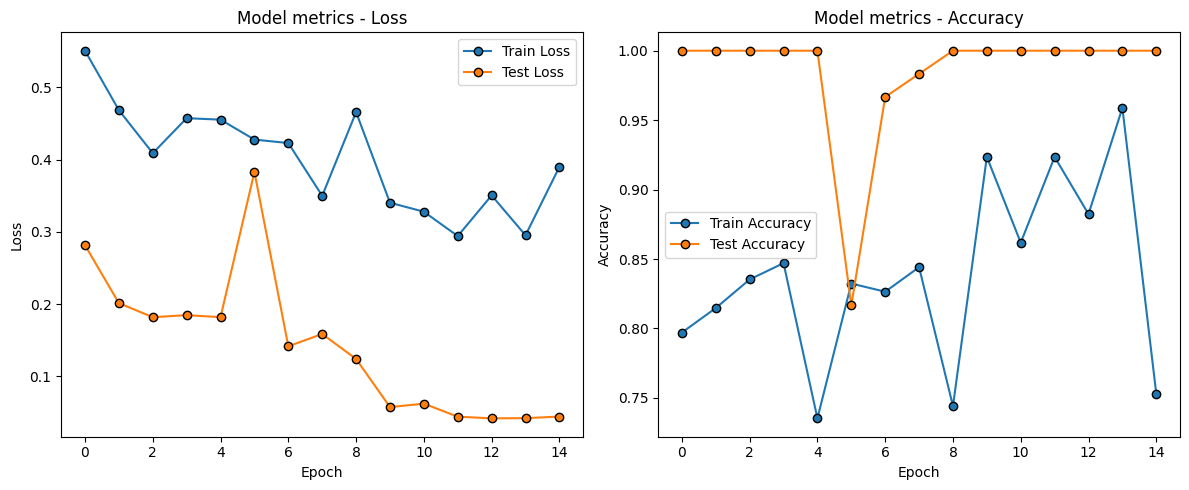

In [37]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(combined_train_losses, label='Train Loss', marker='o', markeredgecolor='black')
plt.plot(combined_test_losses, label='Test Loss', marker='o', markeredgecolor='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model metrics - Loss')

plt.subplot(1, 2, 2)
plt.plot(combined_train_accuracies, label='Train Accuracy', marker='o', markeredgecolor='black')
plt.plot(combined_test_accuracies, label='Test Accuracy', marker='o', markeredgecolor='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model metrics - Accuracy')
plt.tight_layout()

# plt.subplot(1, 3, 3)
# plt.plot(learning_rates, label='Learning Rate', marker='o', markeredgecolor='black', color='blue')
# # plt.plot(test_accuracies, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.legend()
# plt.title('Model metrics - LR')
# plt.tight_layout()

plt.show()

In [38]:
# Function to get predictions and true labels
def get_predictions(model, loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)

In [39]:
# Get predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_pred, y_true = get_predictions(model, val_loader, device)

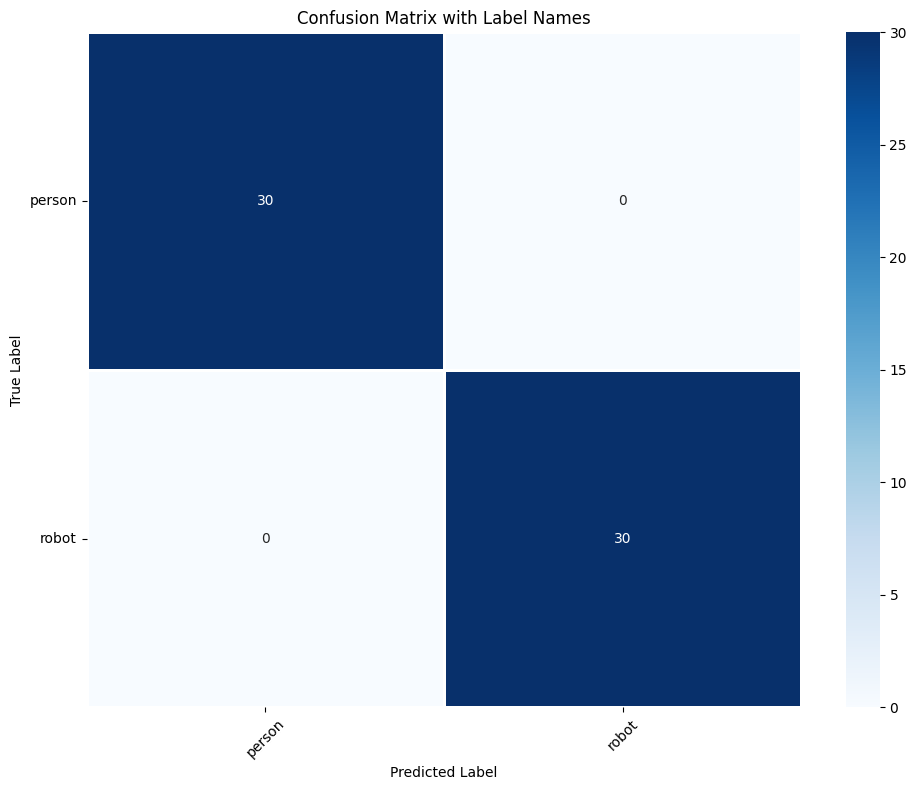

In [40]:
label_names = ['person', 'robot']
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names, linewidths=1)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Label Names')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()